#### Import libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from PIL.Image import Image
from pprint import pprint
import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)

import pyLDAvis
import pyLDAvis.gensim_models
from gensim.models import LdaMulticore, LdaModel
import gensim.corpora as corpora

import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode

from sem_covid.services.sc_wrangling.feature_selector import reduce_array_column
from sem_covid.services.data_registry import Dataset
from sem_covid.services.pwdb_base_experiment import PWDBBaseExperiment
from sem_covid.entrypoints.notebooks.topic_modeling.topic_modeling_wrangling.topic_visualizer import generate_wordcloud

/opt/conda/lib/python3.8/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
/opt/conda/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


ModuleNotFoundError: No module named 'sem_covid'

#### Download dataset

In [36]:
pwdb = Dataset.PWDB.fetch()

[2021-05-13 12:55:53,901] {data_source.py:51} INFO - Fetching ds_pwdb from the local cache


#### Use base experiment function to concatenate and clean text data

In [65]:
pwdb_preprocessing = PWDBBaseExperiment.prepare_pwdb_data(pwdb)
pwdb_text_data = pwdb_preprocessing['descriptive_data']
refactored_text_data = reduce_array_column(pwdb_preprocessing, 'descriptive_data', 'refactored_descriptive_data')
words = refactored_text_data['refactored_descriptive_data'].values
data = pwdb_text_data.values.tolist()


In [69]:
type(data)

list

In [48]:
pwdb_text_data

_id
adc5c75937bc7f7198f534d08b85bd50c9521bfd3f319a090932b5d0bae54de0    [agreement, teleworking, regime, covid, crisis...
2372d71eb9ad6e6a70982e02bbe802db004ed49d91b2264c0a2e8e41571002cc    [special, protection, covid, risk, groups, wor...
8735e268191e9e5cbd3d2a44ca53d297e31746b5f1e24b941db6225a25848353    [funds, innovative, renewable, projects, andal...
18bcd22116c46919e03a3345f793c3859855227ac942e69dd13cbfcd588e1044    [waiver, advance, payments, social, health, in...
b94d8aa95fbdeb1bb832b01fbe5d6e9bf9fc36fceb14f7ba370a963f472fe35b    [financial, shield, small, mediumsized, enterp...
                                                                                          ...                        
cb014a456b14c3621dd318a12e611f70c2a9636be9fe181072bd4bf5917a40fa    [automatic, extension, unemployment, benefits,...
d233b17dc2b98f14269c2b22be78d93ec5ccf2a0013b86f09175c69353c5800b    [extra, subsidies, institutions, cultural, inf...
77d7e3c52aaf78bdfb1a1667641db1293bbff862440c547fc3f6

#### Create wordcloud

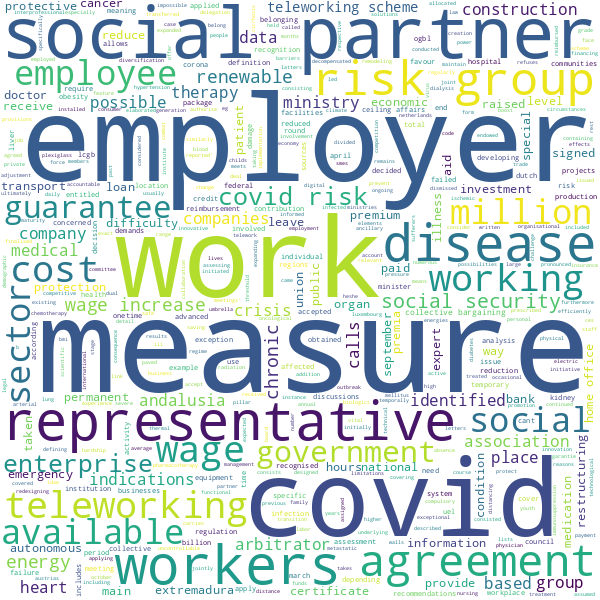

In [54]:
generate_wordcloud(str(words))

#### Put words into dictionary

In [66]:
id2word = corpora.Dictionary(data)
corpus = [id2word.doc2bow(text) for text in pwdb_text_data.reset_index(drop=True)]


[2021-05-13 13:12:43,785] {dictionary.py:200} INFO - adding document #0 to Dictionary(0 unique tokens: [])
[2021-05-13 13:12:43,997] {dictionary.py:205} INFO - built Dictionary(13339 unique tokens: ['', 'accept', 'accountable', 'agreement', 'annual']...) from 1288 documents (total 239493 corpus positions)
[2021-05-13 13:12:43,998] {utils.py:448} INFO - Dictionary lifecycle event {'msg': "built Dictionary(13339 unique tokens: ['', 'accept', 'accountable', 'agreement', 'annual']...) from 1288 documents (total 239493 corpus positions)", 'datetime': '2021-05-13T13:12:43.998531', 'gensim': '4.0.1', 'python': '3.8.5 (default, Jan 27 2021, 15:41:15) \n[GCC 9.3.0]', 'platform': 'Linux-5.8.0-50-generic-x86_64-with-glibc2.29', 'event': 'created'}


#### View the frequency of each word

In [14]:
term_frequency = [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

#### LDA model training

In [67]:
lda_model = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=10, random_state=100,
                         chunksize=10, passes=10, alpha="symmetric", iterations=100, per_word_topics=True)

[2021-05-13 13:12:56,364] {ldamodel.py:567} INFO - using symmetric alpha at 0.1
[2021-05-13 13:12:56,366] {ldamodel.py:567} INFO - using symmetric eta at 0.1
[2021-05-13 13:12:56,371] {ldamodel.py:484} INFO - using serial LDA version on this node
[2021-05-13 13:12:56,385] {ldamulticore.py:238} INFO - running online LDA training, 10 topics, 10 passes over the supplied corpus of 1288 documents, updating every 30 documents, evaluating every ~300 documents, iterating 100x with a convergence threshold of 0.001000
[2021-05-13 13:12:56,392] {ldamulticore.py:279} INFO - training LDA model using 3 processes
[2021-05-13 13:12:56,438] {ldamulticore.py:294} INFO - PROGRESS: pass 0, dispatched chunk #0 = documents up to #10/1288, outstanding queue size 1
[2021-05-13 13:12:56,442] {ldamulticore.py:294} INFO - PROGRESS: pass 0, dispatched chunk #1 = documents up to #20/1288, outstanding queue size 2
[2021-05-13 13:12:56,445] {ldamulticore.py:294} INFO - PROGRESS: pass 0, dispatched chunk #2 = documen

In [68]:
pprint(lda_model.print_topics())

[2021-05-13 13:14:08,120] {ldamodel.py:1185} INFO - topic #0 (0.100): 0.021*"safety" + 0.019*"health" + 0.016*"covid" + 0.016*"production" + 0.012*"occupational" + 0.012*"industry" + 0.012*"protocol" + 0.011*"testing" + 0.010*"measures" + 0.010*"test"
[2021-05-13 13:14:08,125] {ldamodel.py:1185} INFO - topic #1 (0.100): 0.037*"agreement" + 0.033*"employees" + 0.033*"working" + 0.018*"hours" + 0.016*"collective" + 0.016*"time" + 0.015*"employer" + 0.014*"workers" + 0.014*"days" + 0.013*"period"
[2021-05-13 13:14:08,128] {ldamodel.py:1185} INFO - topic #2 (0.100): 0.015*"services" + 0.012*"uk" + 0.010*"products" + 0.009*"facilities" + 0.009*"online" + 0.009*"staff" + 0.009*"food" + 0.009*"business" + 0.008*"sales" + 0.008*"customers"
[2021-05-13 13:14:08,130] {ldamodel.py:1185} INFO - topic #3 (0.100): 0.021*"million" + 0.019*"sector" + 0.019*"support" + 0.016*"measures" + 0.014*"government" + 0.010*"cultural" + 0.010*"sectors" + 0.009*"tourism" + 0.008*"package" + 0.008*"announced"
[202

#### Format topic sentence

In [74]:
def format_topic_sentences(lda_model=None, corpus: list = corpus, words: list = data):
    sent_topics_df = pd.DataFrame()

    for i, row_list in enumerate(lda_model[corpus]):
        row = row_list[0] if lda_model.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)

        for j, (topic_number, prop_number) in enumerate(row):
            if j == 0:
                word_propositions = lda_model.show_topic(topic_number)
                topic_keywords = ", ".join([word for word, prop in word_propositions])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_number), round(prop_number, 4),
                                                                  topic_keywords]), ignore_index=True)
            else:
                break

    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    contents = pd.Series(words)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)

    return sent_topics_df

In [78]:
df_topic_sents_keywords = format_topic_sentences(lda_model=lda_model, corpus=corpus, words=data)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9.0,0.7379,"social, employees, work, workers, company, mea...","[agreement, teleworking, regime, covid, crisis..."
1,1,5.0,0.6020,"health, care, covid, public, services, service...","[special, protection, covid, risk, groups, wor..."
2,2,3.0,0.9580,"million, sector, support, measures, government...","[funds, innovative, renewable, projects, andal..."
3,3,4.0,0.7505,"support, scheme, measure, companies, covid, bu...","[waiver, advance, payments, social, health, in..."
4,4,6.0,0.8514,"loans, loan, companies, million, enterprises, ...","[financial, shield, small, mediumsized, enterp..."
...,...,...,...,...,...
1283,1283,8.0,0.4649,"social, benefit, income, unemployment, measure...","[automatic, extension, unemployment, benefits,..."
1284,1284,3.0,0.7681,"million, sector, support, measures, government...","[extra, subsidies, institutions, cultural, inf..."
1285,1285,6.0,0.3907,"loans, loan, companies, million, enterprises, ...","[expanding, business, loan, guarantee, scheme,..."
1286,1286,4.0,0.4128,"support, scheme, measure, companies, covid, bu...","[collective, working, time, reduction, compani..."


#### The most representative sentence for each topic

In [79]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)],
                                            axis=0)

# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)


,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.6656,"safety, health, covid, production, occupationa...","[covid, faq, guidelines, employers, automotive..."
1,1.0,0.9232,"agreement, employees, working, hours, collecti...","[frame, agreement, working, time, regulations,..."
2,2.0,0.6248,"services, uk, products, facilities, online, st...","[online, platform, quarantine, internet, intro..."
3,3.0,0.9896,"million, sector, support, measures, government...","[support, professionals, creative, industries,..."
4,4.0,0.9955,"support, scheme, measure, companies, covid, bu...","[state, sponsorship, scheme, businesses, selfe..."
5,5.0,0.7604,"health, care, covid, public, services, service...","[regularisation, immigrants, presence, nationa..."
6,6.0,0.8879,"loans, loan, companies, million, enterprises, ...","[special, anticrisis, financing, natioanl, cre..."
7,7.0,0.7308,"tax, payment, implement, income, statement, pa...","[writing, renters, income, tax, liability, sec..."
8,8.0,0.9948,"social, benefit, income, unemployment, measure...","[lump, sum, pensioners, disabled, people, law,..."
9,9.0,0.9916,"social, employees, work, workers, company, mea...","[specific, covid, related, hr, measures, compa..."


#### Analyzing LDA model results


In [84]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.084465  0.070822       1        1  27.627344
4      0.183851 -0.091460       2        1  18.211687
8      0.194875  0.085167       3        1  11.784435
3      0.061840 -0.199392       4        1  10.653541
1      0.101346  0.222894       5        1   8.604798
6      0.053798 -0.192390       6        1   6.640533
5     -0.099944  0.160229       7        1   5.357671
2     -0.218108 -0.091483       8        1   4.794469
0     -0.213896  0.065978       9        1   3.715439
7     -0.148228 -0.030363      10        1   2.610083, topic_info=           Term         Freq        Total Category  logprob  loglift
36    employees  1997.000000  1997.000000  Default  30.0000  30.0000
189      health   958.000000   958.000000  Default  29.0000  29.0000
535         tax   543.000000   543.000000  Default  28.0000  28.0000
3     agreement   890.000000   890.000000  Default  27.0000  27.0000
101     working  1094.000000  1094.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
223         law    49.245017   606.720296  Topic10  -4.8437   1.1345
262    personal    35.374319   152.224064  Topic10  -5.1745   2.1864
4        annual    34.676132   144.694546  Topic10  -5.1944   2.2172
380         act    35.082328   409.101042  Topic10  -5.1828   1.1895
1258   interest    30.381621   210.047825  Topic10  -5.3267   1.7123

[649 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
2700      2  0.250368  accommodation
2700      4  0.734775  accommodation
2700      8  0.010886  accommodation
380       1  0.036666            act
380       2  0.068443            act
...     ...       ...            ...
103       3  0.415679          years
103       6  0.361850          years
540       6  0.978205              z
1110      3  0.982465        ziuzeop
6654      3  0.957564       ziuzeopa

[1297 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 5, 9, 4, 2, 7, 6, 3, 1, 8])

#### Frequency Distribution of Word Counts in Documents

In [92]:
def plotly_bar_chart_graphic(chart_title: str, x_axis: pd.DataFrame, y_axis,
                             x_axis_title: str, y_axis_title: str):
    """
    assuming we want to represent in graphic chart specific data
    :chart_title: graphic title
    :x_axis: our DataFrame we will use as x axis
    :y_axis: our DataFrame we will use as y axis
    :x_axis_title: the title for our x axis
    :y_axis_title: the title for our y axis
    :return: bar chart graphic
    """
    layout = {"title": chart_title,
              "xaxis": {"title": x_axis_title},
              "yaxis": {"title": y_axis_title}}

    trace = go.Bar(x = x_axis,
                   y = y_axis)

    figure = go.Figure(data=trace, layout=layout)
    iplot(figure)

In [94]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

plotly_bar_chart_graphic("Frequency Distribution of Word Counts in Documents",
                         df_dominant_topic['Document_No'], doc_lens,
                         "Number of documents", "Word count")

#### Sentence Chart Colored by Topic

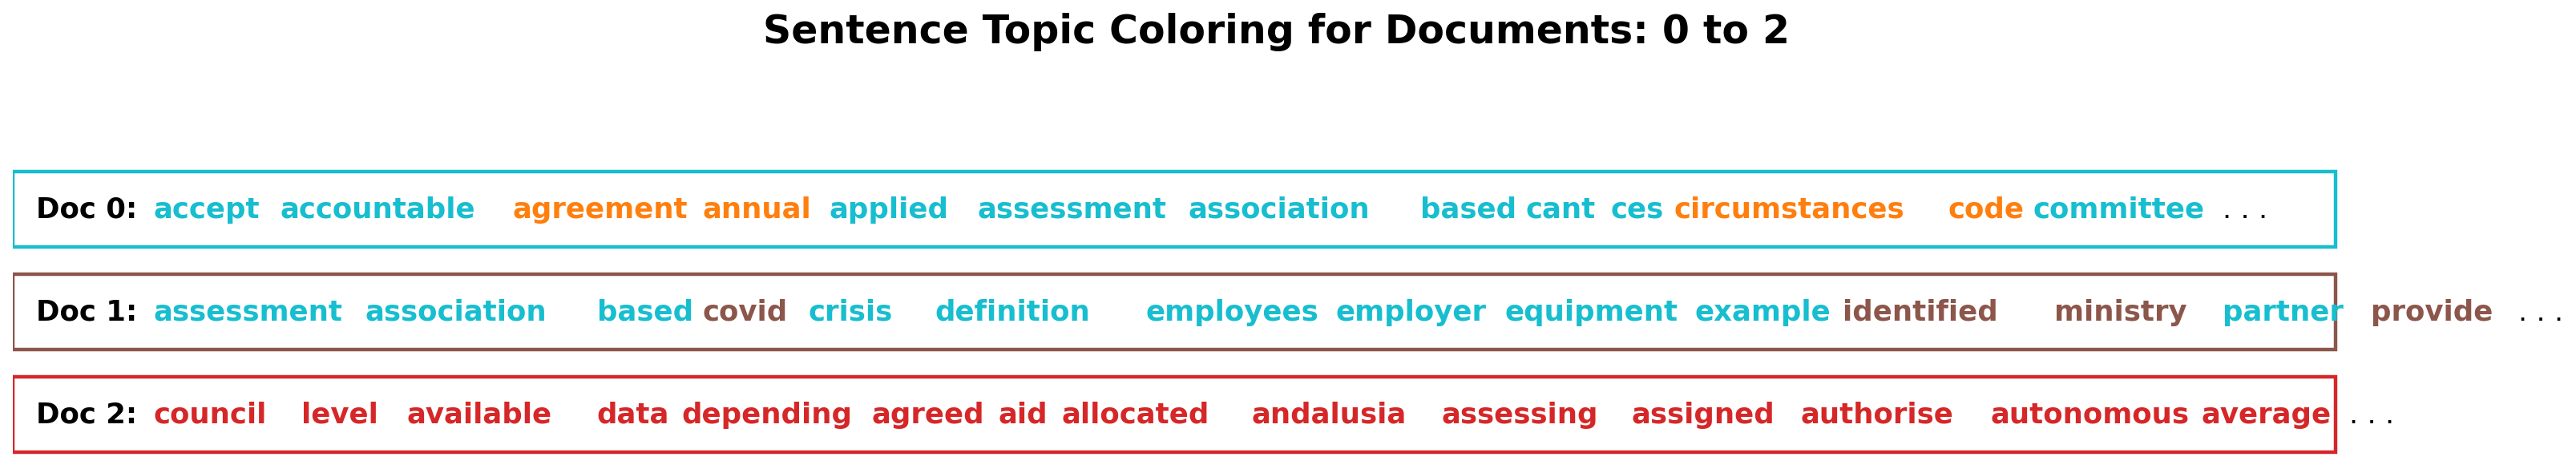

In [102]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 4):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1]
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1,
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()
